In [ ]:
#A Hybrid Transformer Model for Fake News Detection: Leveraging Bayesian Optimization and Bidirectional Recurrent Unit
# import nltk
# nltk.download('punkt')
# nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
import pandas as pd
import numpy as np
import re
import string
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from transformers import BertTokenizer, BertModel
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import GRU
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


import warnings
warnings.filterwarnings("ignore")
nltk.download('stopwords')
nltk.download('wordnet')

c:\Users\PC\OneDrive\Desktop\AI Projects\fake news detection\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
# stop_words = set(stopwords.words("english"))
# lemmatizer = WordNetLemmatizer()

# def clean_text(text):
#     text = str(text).lower()
#     text = re.sub(r"http\S+", "", text)
#     text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
#     words = text.split()
#     words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
#     return " ".join(words)

# def load_liar_dataset(folder):
#     cols = ['label', 'statement', 'subject', 'speaker', 'speaker_job',
#             'state_info', 'party_affiliation', 'barely_true_counts',
#             'false_counts', 'half_true_counts', 'mostly_true_counts',
#             'pants_on_fire_counts', 'context']
#     train = pd.read_csv("train.tsv", sep='\t', names=cols)
#     valid = pd.read_csv("valid.tsv", sep='\t', names=cols)
#     test = pd.read_csv("test.tsv", sep='\t', names=cols)
#     df = pd.concat([train, valid, test])
#     fake_labels = ['pants-fire', 'false', 'barely-true']
#     real_labels = ['half-true', 'mostly-true', 'true']
#     df = df[df['label'].isin(fake_labels + real_labels)]
#     df['label'] = df['label'].apply(lambda x: 0 if x in fake_labels else 1)
#     df['text'] = df['statement'].apply(clean_text)
#     return df[['text', 'label']]

# def load_isot_dataset(path):
#     df = pd.read_csv(path)
#     df['label'] = df['label'].map({"FAKE": 0, "REAL": 1})
#     df['text'] = df['text'].apply(clean_text)
#     return df[['text', 'label']]

In [3]:
# Set up cleaning tools
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

# 🔧 Text cleaning function
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return " ".join(words)

# 🗂️ Load LIAR dataset
def load_liar_dataset(train_path, valid_path, test_path):
    cols = ['label', 'statement', 'subject', 'speaker', 'speaker_job',
            'state_info', 'party_affiliation', 'barely_true_counts',
            'false_counts', 'half_true_counts', 'mostly_true_counts',
            'pants_on_fire_counts', 'context']
    
    train = pd.read_csv(train_path, sep='\t', names=cols)
    valid = pd.read_csv(valid_path, sep='\t', names=cols)
    test  = pd.read_csv(test_path,  sep='\t', names=cols)
    
    df = pd.concat([train, valid, test])
    
    fake_labels = ['pants-fire', 'false', 'barely-true']
    real_labels = ['half-true', 'mostly-true', 'true']
    
    df = df[df['label'].isin(fake_labels + real_labels)]
    df['label'] = df['label'].apply(lambda x: 0 if x in fake_labels else 1)
    df['text'] = df['statement'].apply(clean_text)
    
    return df[['text', 'label']]

# 🗂️ Load ISOT dataset (Kaggle version with separate files)
def load_isot_dataset_kaggle(true_path, fake_path):
    true_df = pd.read_csv(true_path)
    fake_df = pd.read_csv(fake_path)
    
    true_df['label'] = 1
    fake_df['label'] = 0
    
    true_df['text'] = true_df['text'].apply(clean_text)
    fake_df['text'] = fake_df['text'].apply(clean_text)
    
    isot = pd.concat([true_df[['text', 'label']], fake_df[['text', 'label']]], ignore_index=True)
    return isot

# 📥 Load both datasets
df_liar = load_liar_dataset("train.tsv", "valid.tsv", "test.tsv")
df_isot = load_isot_dataset_kaggle("True.csv", "Fake.csv")

# 🔗 Merge and shuffle
df = pd.concat([df_liar, df_isot], ignore_index=True)
df = df.sample(frac=1.0, random_state=42).reset_index(drop=True)

# ✅ Final DataFrame
print(df.head())
print("Shape:", df.shape)
print("Label Distribution:\n", df['label'].value_counts())

                                                text  label
0  several high school senior texas high old time...      0
1  group called people action held big gathering ...      0
2  state florida additional cost implementation c...      1
3  brussels reuters britain 10 day left deliver t...      1
4  say scott walker defunding planned parenthood ...      1
Shape: (57689, 2)
Label Distribution:
 label
0    29138
1    28551
Name: count, dtype: int64


In [4]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_NUM_WORDS = 20000
MAX_SEQ_LEN = 100
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(df['text'].values)
sequences = tokenizer.texts_to_sequences(df['text'].values)
X = pad_sequences(sequences, maxlen=MAX_SEQ_LEN)
y = df['label'].values

In [5]:
embedding_index = {}
with open("glove.6B.100d.txt", encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coeffs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coeffs

word_index = tokenizer.word_index
embedding_matrix = np.zeros((MAX_NUM_WORDS, EMBEDDING_DIM))
for word, i in word_index.items():
    if i < MAX_NUM_WORDS and word in embedding_index:
        embedding_matrix[i] = embedding_index[word]

In [20]:
np.save("embedding_matrix.npy", embedding_matrix)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
class TransformerGRUClassifier(nn.Module):
    def __init__(self, embedding_matrix, model_dim=100, num_heads=2, gru_hidden=64, dropout=0.3, num_classes=2):
        super(TransformerGRUClassifier, self).__init__()
        vocab_size, embed_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float32), freeze=False)
        self.pos_encoder = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, batch_first=True)
        self.transformer = nn.TransformerEncoder(self.pos_encoder, num_layers=1)
        self.bigru = nn.GRU(embed_dim, gru_hidden, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(gru_hidden * 2, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x = self.transformer(x)
        out, _ = self.bigru(x)
        out = self.dropout(out[:, -1, :])
        return self.fc(out)

In [8]:
X_train_tensor = torch.tensor(X_train, dtype=torch.long)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TransformerGRUClassifier(embedding_matrix).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 12
train_accuracies, train_losses = [], []
val_accuracies, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    total_loss, correct = 0, 0
    
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == y_batch).sum().item()

    train_acc = correct / len(train_loader.dataset)
    train_loss = total_loss / len(train_loader)
    train_accuracies.append(train_acc)
    train_losses.append(train_loss)

    model.eval()
    total_val_loss, correct_val = 0, 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            total_val_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct_val += (preds == y_batch).sum().item()

    val_acc = correct_val / len(test_loader.dataset)
    val_loss = total_val_loss / len(test_loader)
    val_accuracies.append(val_acc)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Acc={train_acc:.4f} | Val Loss={val_loss:.4f}, Acc={val_acc:.4f}")

Epoch 1: Train Loss=0.2423, Acc=0.8740 | Val Loss=0.2024, Acc=0.8963
Epoch 2: Train Loss=0.1711, Acc=0.9083 | Val Loss=0.1811, Acc=0.8970
Epoch 3: Train Loss=0.1438, Acc=0.9245 | Val Loss=0.1938, Acc=0.9002
Epoch 4: Train Loss=0.1238, Acc=0.9386 | Val Loss=0.2176, Acc=0.8990
Epoch 5: Train Loss=0.1065, Acc=0.9495 | Val Loss=0.2240, Acc=0.8982
Epoch 6: Train Loss=0.0872, Acc=0.9601 | Val Loss=0.2538, Acc=0.8983
Epoch 7: Train Loss=0.0726, Acc=0.9669 | Val Loss=0.2831, Acc=0.8995
Epoch 8: Train Loss=0.0620, Acc=0.9726 | Val Loss=0.3023, Acc=0.8965
Epoch 9: Train Loss=0.0513, Acc=0.9783 | Val Loss=0.3524, Acc=0.8915
Epoch 10: Train Loss=0.0476, Acc=0.9803 | Val Loss=0.4108, Acc=0.8946
Epoch 11: Train Loss=0.0380, Acc=0.9850 | Val Loss=0.4062, Acc=0.8924
Epoch 12: Train Loss=0.0338, Acc=0.9870 | Val Loss=0.4456, Acc=0.8917


              precision    recall  f1-score   support

        FAKE       0.88      0.91      0.90      5849
        REAL       0.91      0.87      0.89      5689

    accuracy                           0.89     11538
   macro avg       0.89      0.89      0.89     11538
weighted avg       0.89      0.89      0.89     11538



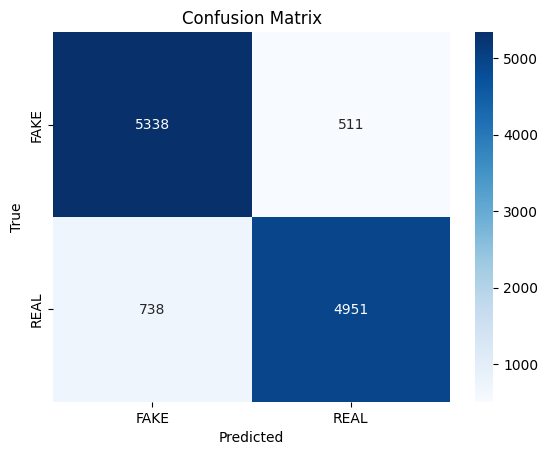

In [10]:
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(y_batch.numpy())

print(classification_report(all_labels, all_preds, target_names=['FAKE', 'REAL']))

cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['FAKE', 'REAL'], yticklabels=['FAKE', 'REAL'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

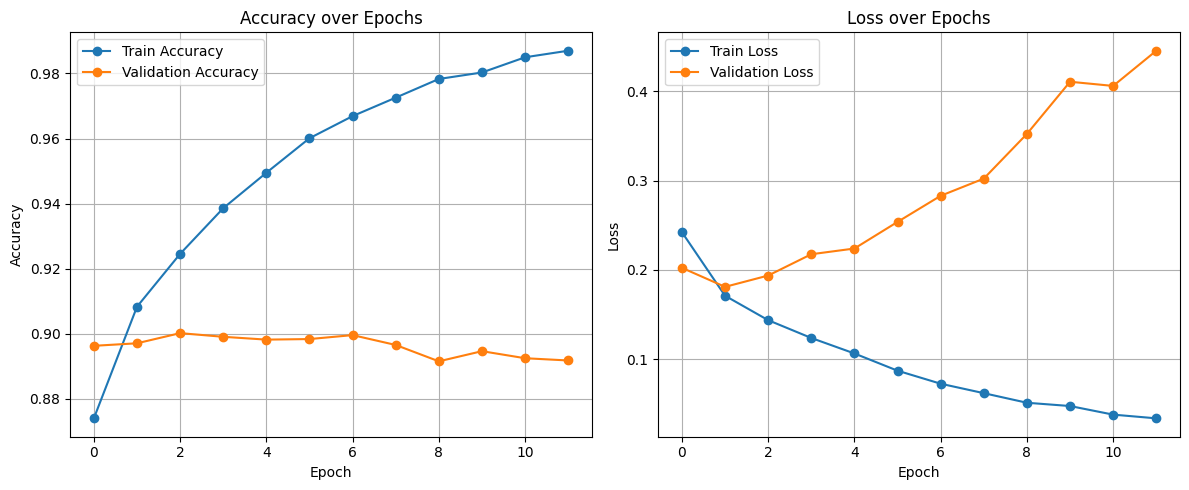

In [11]:
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Accuracy', marker='o')
plt.plot(val_accuracies, label='Validation Accuracy', marker='o')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='o')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [12]:
def predict_fake_news_verbose(text):
    model.eval()
    cleaned = clean_text(text)
    
    # Tokenize and pad
    seq = tokenizer.texts_to_sequences([cleaned])
    padded = pad_sequences(seq, maxlen=MAX_SEQ_LEN)
    
    # Convert to tensor and send to device
    input_tensor = torch.tensor(padded, dtype=torch.long).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        prob = torch.softmax(output, dim=1).cpu().numpy()[0]
        pred = torch.argmax(output, dim=1).item()

    print(f"Text: {text}")
    print(f"→ Prediction: {'REAL' if pred == 1 else 'FAKE'} | Probabilities: [FAKE: {prob[0]:.2f}, REAL: {prob[1]:.2f}]")

In [13]:
predict_fake_news_verbose("Joe Biden announced new education reforms during a press conference.")
predict_fake_news_verbose("Breaking: Aliens have landed on the White House lawn!")

Text: Joe Biden announced new education reforms during a press conference.
→ Prediction: REAL | Probabilities: [FAKE: 0.12, REAL: 0.88]
Text: Breaking: Aliens have landed on the White House lawn!
→ Prediction: FAKE | Probabilities: [FAKE: 1.00, REAL: 0.00]


In [14]:
def predict_fake_news_verbose(text, threshold=0.6):
    model.eval()
    cleaned = clean_text(text)
    seq = tokenizer.texts_to_sequences([cleaned])
    padded = pad_sequences(seq, maxlen=MAX_SEQ_LEN)
    input_tensor = torch.tensor(padded, dtype=torch.long).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        prob = torch.softmax(output, dim=1).cpu().numpy()[0]
        pred = torch.argmax(output, dim=1).item()

    print(f"Text: {text}")
    print(f"→ Raw Probabilities: [FAKE: {prob[0]:.2f}, REAL: {prob[1]:.2f}]")

    if max(prob) < threshold:
        print("⚠️ Low confidence prediction — this may be an edge case.")
    else:
        print(f"→ Prediction: {'REAL' if pred == 1 else 'FAKE'} | Confidence: {max(prob):.2f}")

In [17]:
# High confidence example
predict_fake_news_verbose("Joe Biden announced new education reforms during a press conference.")

# Low confidence / ambiguous example
predict_fake_news_verbose("A new report suggests changes in voting patterns.")

# You can also test the confidence threshold explicitly
predict_fake_news_verbose("Aliens seen in Washington D.C.", threshold=0.9)

Text: Joe Biden announced new education reforms during a press conference.
→ Raw Probabilities: [FAKE: 0.12, REAL: 0.88]
→ Prediction: REAL | Confidence: 0.88
Text: A new report suggests changes in voting patterns.
→ Raw Probabilities: [FAKE: 1.00, REAL: 0.00]
→ Prediction: FAKE | Confidence: 1.00
Text: Aliens seen in Washington D.C.
→ Raw Probabilities: [FAKE: 1.00, REAL: 0.00]
→ Prediction: FAKE | Confidence: 1.00


In [ ]:
# import csv

# def log_prediction(text, pred, prob):
#     with open("prediction_logs.csv", mode="a", newline='', encoding="utf-8") as file:
#         writer = csv.writer(file)
#         writer.writerow([text, 'REAL' if pred == 1 else 'FAKE', f"{prob[0]:.4f}", f"{prob[1]:.4f}"])


In [18]:
# Save model
torch.save(model.state_dict(), "fake_news_model.pt")
# Optionally save tokenizer using pickle
import pickle
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

In [19]:
torch.save(model.state_dict(), "fake_news_model.pth")

In [22]:
from keras_preprocessing.text import tokenizer_from_json

# Save tokenizer as JSON
tokenizer_json = tokenizer.to_json()
with open("tokenizer.json", "w") as f:
    f.write(tokenizer_json)